# Find the Most Representive songs of the singer

## Idea

1. Have lyrics of each singer, use that to build a VSM
2. Sort lyric vectors, find the most important terms of each song (like top 30 terms)
3. Get all the important terms of each song together, sort them by df, then choose the top [100] terms as the represent terms of this singer.
4. For each lyric vector, sum the representive terms' weight together, treat it as this song's score
5. Find the top 20 songs through the scores

In [1]:
import numpy as np
import pandas as pd
import math
import re
import pickle
from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize


In [2]:
def _singer_song_dic(data):
    '''Build singer-song dictionay
    
    Dictionary format:
    {singer_name: {song_name: lyrics}}
    '''
    
    singer_songs = {}
    
    for i in range(len(data)):
        singer = data.iloc[i]['artist']
        song = data.iloc[i]['song']
        lyric = data.iloc[i]['lyrics']
        
        
        if singer not in singer_songs:
            temp = {song: lyric}
            singer_songs[singer] = temp
        else:
            singer_songs[singer][song] = lyric
            
    return singer_songs

In [3]:
from nltk.stem.snowball import SnowballStemmer
def _update_inverted_index(name, lyrics, inverted_index):
    '''Create inverted index, count doc vector length

    Read contents form file, remove punctuation and stopwords to get terms.
    Count tf of this doc, then update inverted index.
    
    inverted_index
    '''
    
    indices = {}
    punctuation = re.compile(r'[^\w\s\']')
    
    ###
    # Count term frequency
    ###
    stop_words = set(stopwords.words('english'))
    #lyrics_split = re.sub(punctuation, ' ', lyrics.lower()).split()
    #TEST: tokenize
    lyrics_split = regexp_tokenize(lyrics.lower(), "[a-z]['a-z]*")
    
    stemmer = SnowballStemmer('english')
    
    
    for term in lyrics_split:
        term = stemmer.stem(term)
        if term in stop_words:
            continue
        elif term in indices:
            indices[term] += 1
        else:
            indices[term] = 1
    
    ###
    # Update inverted_index
    ###
    for term, frequency in indices.items():
        if term in inverted_index:
            posting = inverted_index[term]
            posting.append((name, frequency))
            inverted_index[term] = posting
        else:
            inverted_index[term] = [(name, frequency)]

In [4]:
def _compute_weight(tf, df, n_songs):
    
    idf = math.log(n_songs / df)

    tf_normalized = 1 + math.log(tf)

    weight = tf_normalized * idf
    return weight

In [5]:
def _build_song_vector(inverted_index, n_songs):
    '''Build term-weight vector for songs
    
    Compute the tf-idf weight, {term: weight}
    
    return:
        dic: a dictionary which format is {song: {term: weight}}
    '''
    
    song_vectors = {}
    
    for term, posting in inverted_index.items():
        df = len(posting)
        for pair in posting:
            song, tf = pair
            weight = _compute_weight(tf, df, n_songs)
            if song not in song_vectors:  # Create song vec
                song_vectors[song] = {term: weight}
            else:
                song_vectors[song][term] = weight  # Add new term into vec
                
    return song_vectors

In [6]:
def _get_top_songs(inverted_index, terms):
    '''Count rep terms' frequency, use that to pick rep songs
    
    Args:
        inverted_index: inverted index of this singer's songs
            format => {term: [(song, tf),]}
        terms: this singer's representive terms
    Return:
        top_songs(list): a list that contains the name of songs, order by score
    '''
    
    song_scores = {}
    for term in terms:
        posting = inverted_index[term]
        for song, _ in posting:
            if song in song_scores:
                song_scores[song] += 1
            else:
                song_scores[song] = 1
                
    top_songs = sorted(song_scores.items(), key=lambda kv: kv[1], reverse=True)
    top_songs = [name for name, _ in top_songs]
    return top_songs

In [7]:
def _find_rep_songs(singer, songs, num_of_songs, num_of_terms):
    '''Find the most representive songs of this singer
    
    Choose songs by compare the scores which is sum the weight of each important term in that song.
    
    Args:
        songs(dic): a dictionary {song: lyrics}
        num_of_songs: number of representive songs you want to choose
        num_of_terms: number of important words we want to score the songs
        
    Return:
        rep_songs(dic): a dictionary {song: lyrics}, size will less or equal to num_of_songs
    '''
    global singers_repr_terms
    
    inverted_index = {}
    
    n_songs = len(songs)
    if n_songs <= num_of_songs:  # Do not need to choose if not has enough songs
        num_of_songs = n_songs
    
    # Build inverted index
    for name, lyrics in songs.items():
        _update_inverted_index(name, lyrics, inverted_index)
        
    # build song vector
    song_vectors = _build_song_vector(inverted_index, n_songs)
    
    # sort by weight, get top words (put them into a set)
    selected_terms = set()
    
    for song, vector in song_vectors.items():
        sorted_v = sorted(vector.items(), key=lambda kv: kv[1], reverse=True)
        select_range = sorted_v[:num_of_terms]
        for term, _ in select_range:
            selected_terms.add(term)
    
    # Store this singer's representative terms
    # inverted index: term [song, frequency]
    singers_repr_terms[singer] = {}
    for term in selected_terms:
        posting = inverted_index[term]
        total_tf = 0
        for _, tf in posting:
            total_tf = total_tf + tf
        singers_repr_terms[singer][term] = total_tf
    
    # get score of each song
    song_sorted = _get_top_songs(inverted_index, selected_terms)
    selected_songs = song_sorted[:num_of_songs]
    top_songs = {}
    for name, lyrics in songs.items():
        if name in selected_songs:
            top_songs[name] = lyrics
    
    return top_songs

In [8]:
def get_rep_songs(num_of_songs, num_of_terms, file_path):
    '''Get each singer's representive songs
    
    Args: 
        num_of_songs: number of songs you want to get from each singer
        file_path: path of input data file
    Return:
        dic: A dictionary which format is {singer, {song: lyrics}}
    '''
    
    # Read data from file
    data = pd.read_csv(file_path)
    singer_songs = _singer_song_dic(data)
    
    representive_songs = {}  # return dic
    for singer, songs in singer_songs.items():
        rep = _find_rep_songs(singer, songs, num_of_songs, num_of_terms)
        representive_songs[singer] = rep
    
    with open('../../data/top_songs.pickle', 'wb') as handle:
        pickle.dump(representive_songs, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
        
    return representive_songs

In [10]:
if __name__ == '__main__':
    singers_repr_terms = {}
# TESTing part
files = 'mylyrics00.csv'
get_rep_songs(20, 50, files)
print(singers_repr_terms['eminem'])

{'steamin': 8, 'lampshad': 1, 'farm': 2, 'dj': 36, 'caus': 1708, 'steroid': 4, "n'": 15, 'equival': 6, 'bel': 3, 'avalanch': 1, 'duh': 7, 'deacon': 2, 'inform': 4, 'antagonist': 1, 'kidnappin': 1, 'eddi': 6, 'border': 3, 'kroeger': 1, 'sean': 2, 'vixen': 1, 'allegra': 1, 'decis': 10, 'grimey': 1, 'sorrow': 15, 'plese': 1, 'anyth': 102, 'brang': 1, 'zone': 16, 'oscar': 7, 'honkin': 2, 'scalar': 1, 'proport': 5, 'verbal': 19, 'fittest': 4, 'legibl': 1, 'heaven': 18, 'mya': 2, 'buddha': 1, 'cocksuckin': 2, 'sensor': 2, "dumb'en": 1, 'caper': 2, 'jawbreak': 1, 'doge': 1, 'jussa': 1, 'make': 998, 'sunlight': 3, 'vrum': 4, 'bobbit': 1, 'spend': 18, 'thou': 6, 'brought': 34, 'sideswip': 1, 'goal': 10, 'assassin': 14, 'wa': 2, 'bleed': 25, 'veteran': 5, 'pew': 2, 'devious': 1, 'insertin': 1, 'thrash': 1, 'tact': 3, 'feebl': 1, 'cop': 101, 'pete': 8, 'deflat': 2, 'comic': 5, 'final': 59, 'heartbrok': 2, 'nope': 17, 'ringer': 4, 'chew': 38, 'spider': 20, 'ether': 5, 'witcha': 4, 'brighten': 2, '

eminem and ghostface-killah word comparison


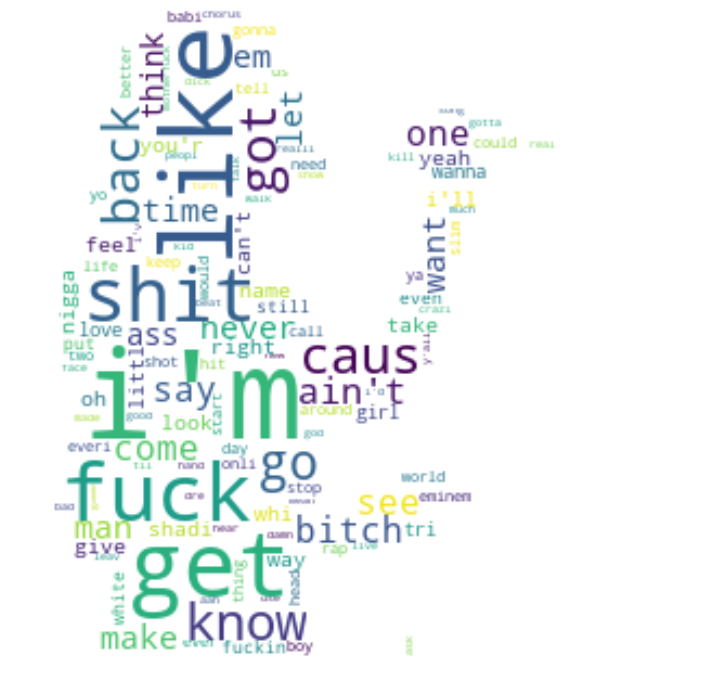

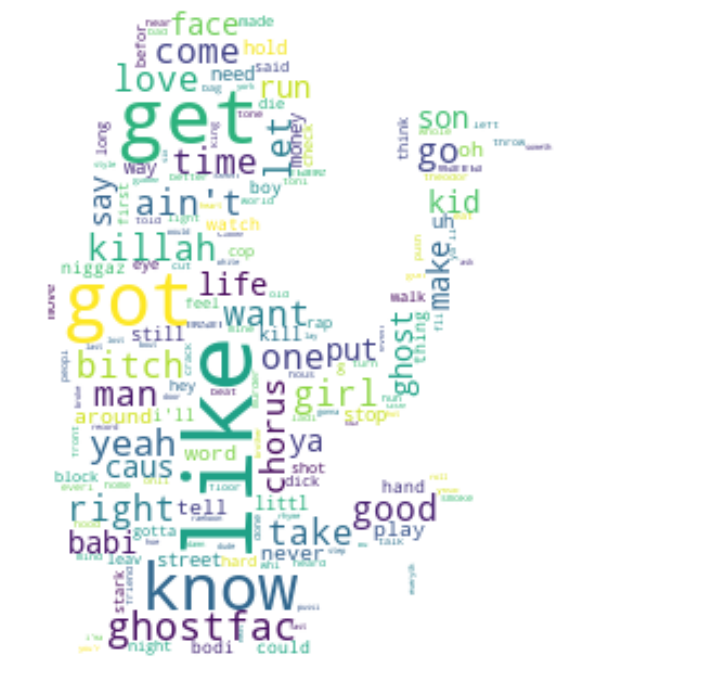

In [12]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from PIL import Image

## dict 형식은 {term or artist : 'value'} 형식으로 들어감
def gen_wordcloud(dict):

    
    icon = Image.open('../singer.jpg')
    mask = Image.new("RGB", icon.size, (255,255,255))
    mask.paste(icon)
    mask = np.array(mask)
       
    wordcloud = WordCloud(background_color = 'white', mask=mask).generate_from_frequencies(dict)

#     plt.imshow(mask, cmap=plt.cm.gray)
    

    plt.figure(figsize=(12,12))
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.show()
    
    
print("eminem and ghostface-killah word comparison")
gen_wordcloud(singers_repr_terms['eminem'])
gen_wordcloud(singers_repr_terms['ghostface-killah'])

